In [1]:
# notebook version of gen.py
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def gen(
        N: int, 
        g_prob: float = 0.25, 
        fixed: bool = True, 
        dimers: bool = False
    ):
    """
    Randomly generate polymer of length N from L and G monomers
    
    Args:
        N (int): length of polymer (number of monomers it contains)
        g_prob (float): probability of G appearance (default=0.25)
        fixed (bool): whether to fix the number of Gs in string
            - True -> randomly generate g_prob * N fixed positions (no replacement) for G monomers
            - False -> every index has a g_prob probability of being a G 
        dimers (bool): whether polymer should be built by pairs of two polymer dimers 
    
    Returns:
        str: generated polymer
    
    Sample Runs:
        (48, 0.25, True, False) -> LLGLLLGLLLLLGLGLLLLLLLLLLGLLLLLGLGGGGLLGLLLLGLLL
        (48, 0.25, True, True) -> LLLLGGLLLLLLLLLLGGLLGGGGLLLLLLLLLLGGLLLLLLLLLLGG
        (48, 0.25, False, False) -> LLLGGLGLLGLLGLLLLGLLLLLLLLLLLLLGLLGLLLGLLGGGGLLL
    """
    
    if dimers:
        N = int(N / 2)

    polymer_pos = []
        
    if fixed: 
        g_idx = np.random.choice(N, int(N * g_prob), replace=False)

        polymer_pos = np.zeros(N, dtype=int)
        polymer_pos[g_idx] = 1
    else:
        polymer_pos = np.array([1 if np.random.random() <  g_prob else 0 for _ in range(N)])

    polymer = ""
    for i in range(N):
        if not dimers:
            if polymer_pos[i] == 1: polymer += "G"
            else: polymer += "L"
        else:
            if polymer_pos[i] == 1: polymer += "GG"
            else: polymer += "LL"
    
    return polymer

In [3]:
def calc_stats(polymer: str):
    """
    Count number of overlapping GG, LL, GL, LG sub dimers

    Args:
        polymer (str): input polymer of L and G monomers

    Returns:
        4 element tuple: (GGs, LLs, GLs, LGs)
    """
    n = len(polymer)

    num_GGs = 0
    for i in range(n - 1):
        if polymer[i] == 'G' and polymer[i+1] == 'G':
            num_GGs += 1
    
    num_LLs = 0
    for i in range(n - 1):
        if polymer[i] == 'L' and polymer[i+1] == 'L':
            num_LLs += 1

    num_GLs = 0
    for i in range(n - 1):
        if polymer[i] == 'G' and polymer[i+1] == 'L':
            num_GLs += 1
    
    num_LGs = 0
    for i in range(n - 1):
        if polymer[i] == 'L' and polymer[i+1] == 'G':
            num_LGs += 1

    return num_GGs, num_LLs, num_GLs, num_LGs

In [4]:
# Adjust generation inputs
N = 10000

p_length = 48
g_rate = 0.25
fix_Gs = True
make_with_dimers = True

GGs, LLs, GLs, LGs = [], [], [], []

In [5]:
with open(f'data/sample_polymers_{p_length}.out', 'w') as f:
    for _ in range(N):
        polymer = gen(p_length, g_prob=g_rate, fixed=fix_Gs, dimers=make_with_dimers)
        f.write(polymer + '\n')

        (GG, LL, GL, LG) = calc_stats(polymer)
        GGs.append(GG)
        LLs.append(LL)
        GLs.append(GL)
        LGs.append(LG)

GGs = np.array(GGs)
LLs = np.array(LLs)
GLs = np.array(GLs)
LGs = np.array(LGs)

In [6]:
print(f"Mean G-Gs: {np.mean(GGs):.2f}")
print(f"SEM G-Gs:  {np.std(GGs) / np.sqrt(N - 1):.2f}")
print("-" * 20)

print(f"Mean L-Ls: {np.mean(LLs):.2f}")
print(f"SEM L-Ls:  {np.std(LLs) / np.sqrt(N - 1):.2f}")
print("-" * 20)

print(f"Mean G-Ls: {np.mean(GLs):.2f}")
print(f"SEM G-Ls:  {np.std(GLs) / np.sqrt(N - 1):.2f}")
print("-" * 20)

print(f"Mean L-Gs: {np.mean(LGs):.2f}")
print(f"SEM L-Gs:  {np.std(LGs) / np.sqrt(N - 1):.2f}")

Mean G-Gs: 7.25
SEM G-Gs:  0.01
--------------------
Mean L-Ls: 30.75
SEM L-Ls:  0.01
--------------------
Mean G-Ls: 4.50
SEM G-Ls:  0.01
--------------------
Mean L-Gs: 4.49
SEM L-Gs:  0.01


In [7]:
# Correct 0s to 1s to avoid divide by 0
for i in range(len(LGs)):
    if(LGs[i] == 0):
        LGs[i] = 1
    if(GLs[i] == 0):
        GLs[i] = 1

print("OTHER METRICS")
print(f"L_L (mean)    = {np.mean(LLs / LGs + 1):.2f}")
print(f"L_L (sem)     = {np.std(LLs / LGs + 1) / np.sqrt(N - 1):.2f}")
print()
print(f"L_G (mean)    = {np.mean(GGs / GLs + 1):.2f}")
print(f"L_G (sem)     = {np.std(GGs / GLs + 1) / np.sqrt(N - 1):.2f}")
print()
print(f"R_c (mean)    = {np.mean(GGs / GLs):.2f}")
print(f"R_c (sem)     = {np.std(GGs / GLs) / np.sqrt(N - 1):.2f}")

OTHER METRICS
L_L (mean)    = 8.27
L_L (sem)     = 0.02

L_G (mean)    = 2.75
L_G (sem)     = 0.01

R_c (mean)    = 1.75
R_c (sem)     = 0.01


In [8]:
N = 10000

DOPs = np.arange(40, 1000, step=40)

L_L_means, L_L_sems = [], []
L_G_means, L_G_sems = [], []
R_c_means, R_c_sems = [], []

In [9]:
for n in DOPs:
    GGs, LLs, GLs, LGs = [], [], [], []
    
    for _ in range(N):
        polymer = gen(n, g_prob=g_rate, fixed=False, dimers=make_with_dimers)

        (GG, LL, GL, LG) = calc_stats(polymer)
        GGs.append(GG)
        LLs.append(LL)
        GLs.append(GL)
        LGs.append(LG)

    GGs = np.array(GGs)
    LLs = np.array(LLs)
    GLs = np.array(GLs)
    LGs = np.array(LGs)
    
    for i in range(len(LGs)):
        if(LGs[i] == 0):
            LGs[i] = 1
        if(GLs[i] == 0):
            GLs[i] = 1
    
    L_L_means.append(np.mean(LLs / LGs + 1))
    L_L_sems.append(np.std(LLs / LGs + 1) / np.sqrt(N - 1))
    
    L_G_means.append(np.mean(GGs / GLs + 1))
    L_G_sems.append(np.std(GGs / GLs + 1) / np.sqrt(N - 1))
    
    R_c_means.append(np.mean(GGs / GLs))
    R_c_sems.append(np.std(GGs / GLs) / np.sqrt(N - 1))

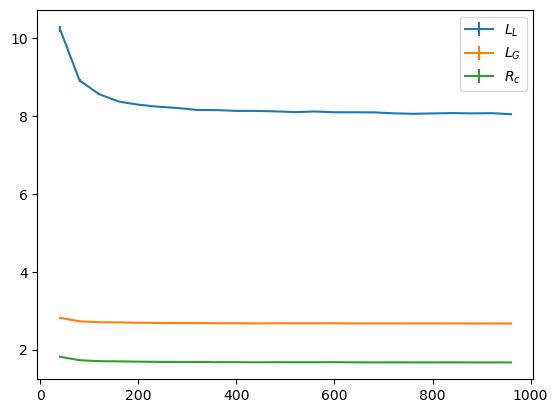

In [10]:
fig, ax = plt.subplots()

ax.errorbar(DOPs, L_L_means, yerr=np.array(L_L_sems), label='$L_L$')
ax.errorbar(DOPs, L_G_means, yerr=np.array(L_G_sems), label='$L_G$')
ax.errorbar(DOPs, R_c_means, yerr=np.array(R_c_sems), label='$R_c$')

ax.legend()